In [1]:
#https://github.com/GPlates/gplately/blob/master/Notebooks/01-GettingStarted.ipynb

In [2]:
import cartopy.crs as ccrs
import gplately
import matplotlib.pyplot as plt
import numpy as np
from plate_model_manager import PlateModelManager

In [3]:
# Call GPlately's PlateModelManager object and request data from the Müller et al. 2019 study
pm_manager = PlateModelManager()
muller2019_model = pm_manager.get_model("Muller2019", data_dir="plate-model-repo")
rotation_model = muller2019_model.get_rotation_model()
topology_features = muller2019_model.get_topologies()
static_polygons = muller2019_model.get_static_polygons()

# Tessellate the subduction zones to 0.5 degrees.
tessellation_threshold_radians = np.radians(0.05)

model = gplately.PlateReconstruction(rotation_model, topology_features, static_polygons)

downloading https://repo.gplates.org/webdav/pmm/muller2019/Rotations.zip
The local file(s) is/are still good. Will not download again at this moment.
downloading https://repo.gplates.org/webdav/pmm/muller2019/Topologies.zip
The local file(s) is/are still good. Will not download again at this moment.
downloading https://repo.gplates.org/webdav/pmm/muller2019/StaticPolygons.zip
The local file(s) is/are still good. Will not download again at this moment.


In [4]:
time = 10

# these bundle a lot of information - check PTT docs for more info
subduction_data = model.tessellate_subduction_zones(time, ignore_warnings=True)
ridge_data = model.tessellate_mid_ocean_ridges(time, ignore_warnings=True)

In [5]:
# Obtain features for the PlotTopologies object with PlateModelManager
coastlines = muller2019_model.get_layer('Coastlines')
continents = muller2019_model.get_layer('ContinentalPolygons')
COBs =  muller2019_model.get_layer('COBs')

# Call the PlotTopologies object
gplot = gplately.plot.PlotTopologies(model, coastlines=coastlines, continents=continents, COBs=COBs)

# Download all Muller et al. 2019 netCDF age grids with PlateModelManager. This is returned as a Raster object.
agegrid = gplately.Raster(data=muller2019_model.get_raster("AgeGrids",time))

downloading https://repo.gplates.org/webdav/pmm/muller2019/Coastlines.zip
The local file(s) is/are still good. Will not download again at this moment.
downloading https://repo.gplates.org/webdav/pmm/muller2019/ContinentalPolygons.zip
The local file(s) is/are still good. Will not download again at this moment.
downloading https://repo.gplates.org/webdav/pmm/muller2019/COBs.zip
The local file(s) is/are still good. Will not download again at this moment.
downloading https://www.earthbyte.org/webdav/ftp/Data_Collections/Muller_etal_2019_Tectonics/Muller_etal_2019_Agegrids/Muller_etal_2019_Tectonics_v2.0_netCDF/Muller_etal_2019_Tectonics_v2.0_AgeGrid-10.nc
The local file(s) is/are still good. Will not download again at this moment.


In [6]:
gplot.time = 10 # Ma

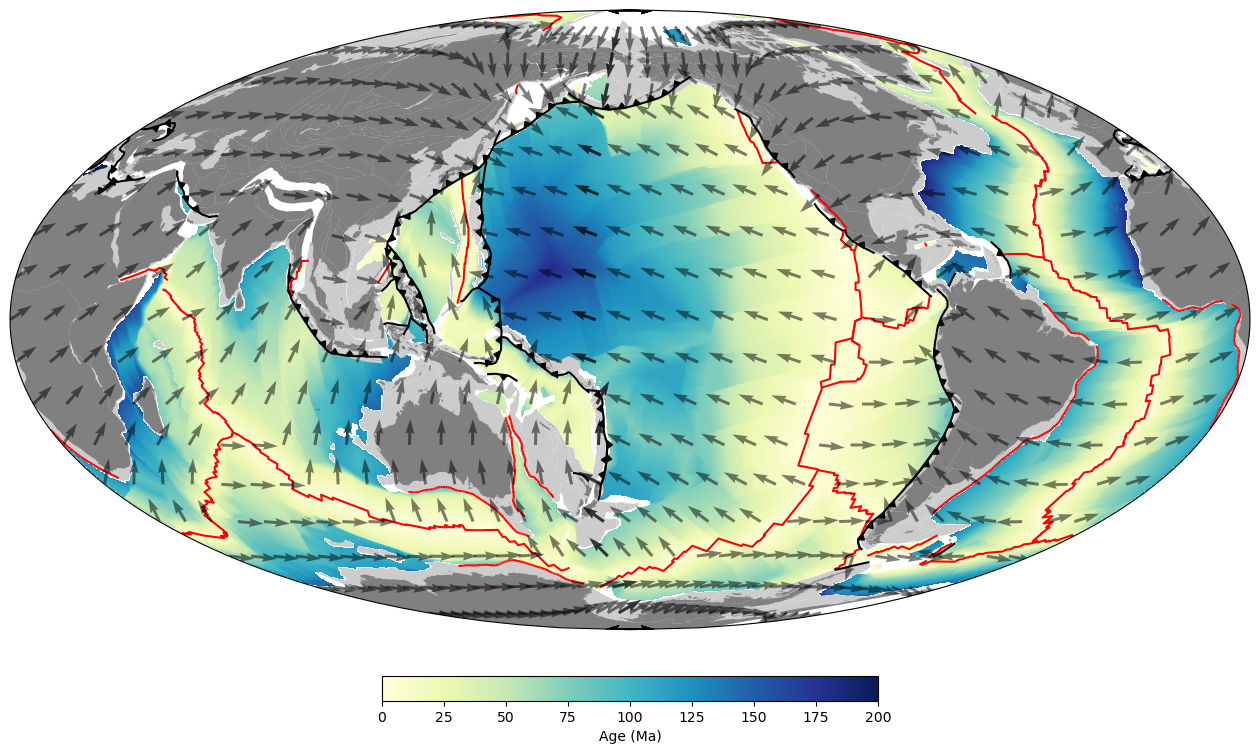

In [7]:
fig = plt.figure(figsize=(16,12))

ax1 = fig.add_subplot(111, projection=ccrs.Mollweide(190))

gplot.plot_continents(ax1, facecolor='0.8')
gplot.plot_coastlines(ax1, color='0.5')
gplot.plot_ridges_and_transforms(ax1, color='red')
gplot.plot_trenches(ax1, color='k')
gplot.plot_subduction_teeth(ax1, color='k')
im = gplot.plot_grid(ax1, agegrid.data, cmap='YlGnBu', vmin=0, vmax=200)
gplot.plot_plate_motion_vectors(ax1, spacingX=10, spacingY=10, normalise=True, zorder=10, alpha=0.5)

fig.colorbar(im, orientation='horizontal', shrink=0.4, pad=0.05, label='Age (Ma)')

downloading https://www.earthbyte.org/webdav/ftp/Data_Collections/Muller_etal_2019_Tectonics/Muller_etal_2019_Agegrids/Muller_etal_2019_Tectonics_v2.0_netCDF/Muller_etal_2019_Tectonics_v2.0_AgeGrid-100.nc
The local file(s) is/are still good. Will not download again at this moment.


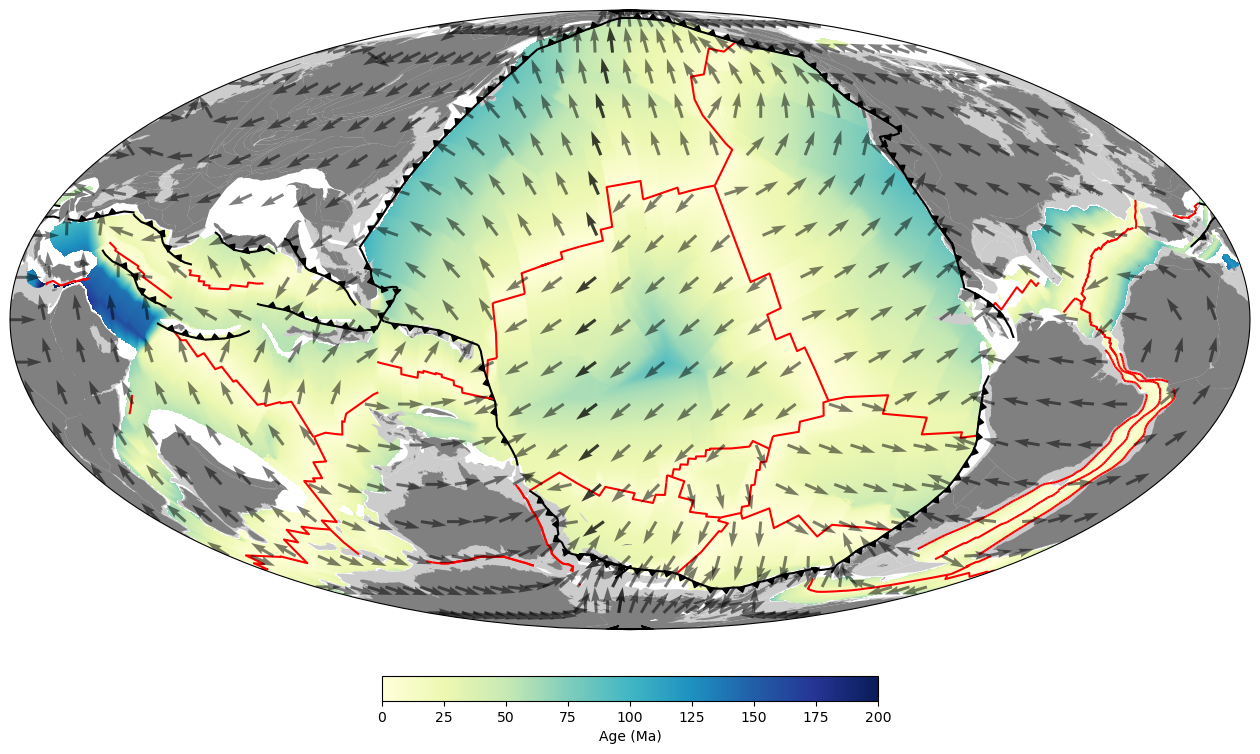

In [8]:
# update the time to regenerate topologies
time = 100
gplot.time = time
agegrid = gplately.Raster(data=muller2019_model.get_raster("AgeGrids",time))

fig = plt.figure(figsize=(16,12))

ax1 = fig.add_subplot(111, projection=ccrs.Mollweide(190))

gplot.plot_continents(ax1, facecolor='0.8')
gplot.plot_coastlines(ax1, color='0.5')
gplot.plot_ridges_and_transforms(ax1, color='red')
gplot.plot_trenches(ax1, color='k')
gplot.plot_subduction_teeth(ax1, color='k')
im = gplot.plot_grid(ax1, agegrid.data, cmap='YlGnBu', vmin=0, vmax=200)
gplot.plot_plate_motion_vectors(ax1, spacingX=10, spacingY=10, normalise=True, zorder=10, alpha=0.5)

fig.colorbar(im, orientation='horizontal', shrink=0.4, pad=0.05, label='Age (Ma)')

In [9]:
pt_lons = np.array([140., 150., 160.])
pt_lats = np.array([-30., -40., -50.])

gpts = gplately.Points(model, pt_lons, pt_lats)

vel_x, vel_y = gpts.plate_velocity(0)
vel_mag = np.hypot(vel_x, vel_y)

print("average point velocity (cm/yr)", vel_mag)

average point velocity (cm/yr) [6.38389518 5.71007208 5.06602802]


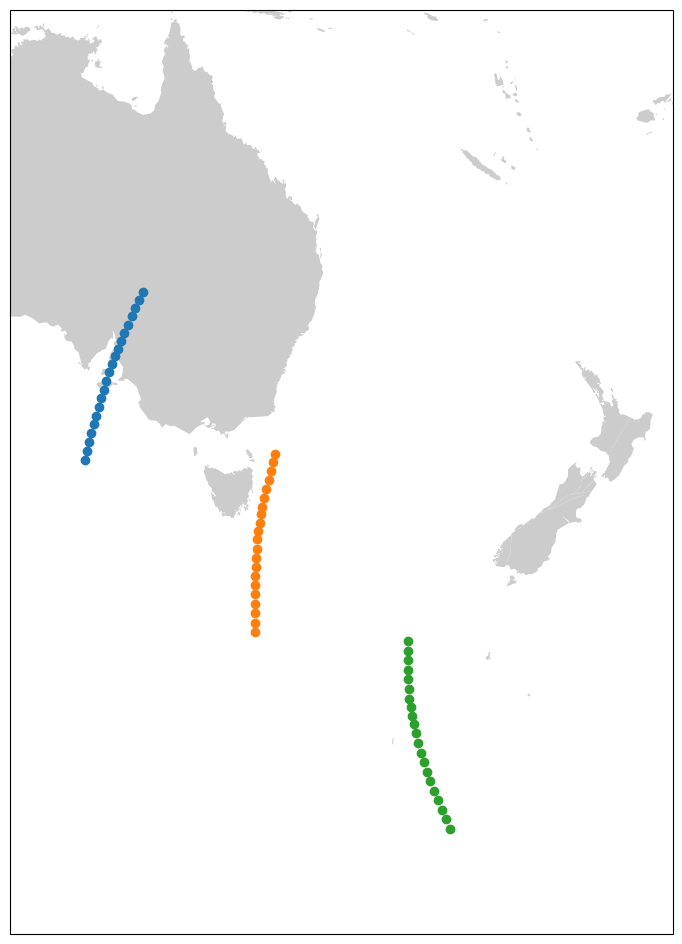

In [10]:
rlons = np.empty((21, pt_lons.size))
rlats = np.empty((21, pt_lons.size))


for time in range(0, 21):
    rlons[time], rlats[time] = gpts.reconstruct(time, return_array=True)
    
gplot.time = 0 # present day

fig = plt.figure(figsize=(16,12))
ax1 = fig.add_subplot(111, projection=ccrs.Mercator(190)) 
ax1.set_extent([130,180,-60,-10])

gplot.plot_coastlines(ax1, color='0.8')

for i in range(0, len(pt_lons)):
    ax1.plot(rlons[:,i], rlats[:,i], 'o', transform=ccrs.PlateCarree())